Epoch 1/100 - Train Loss: 0.4643 - Val Loss: 0.3747 - Val Acc: 0.8558
Epoch 2/100 - Train Loss: 0.2987 - Val Loss: 0.3778 - Val Acc: 0.8562
Epoch 3/100 - Train Loss: 0.2677 - Val Loss: 0.3185 - Val Acc: 0.8717
Epoch 4/100 - Train Loss: 0.2445 - Val Loss: 0.5120 - Val Acc: 0.8251
Epoch 5/100 - Train Loss: 0.2308 - Val Loss: 0.3830 - Val Acc: 0.8612
Epoch 6/100 - Train Loss: 0.2222 - Val Loss: 0.4253 - Val Acc: 0.8315
Epoch 7/100 - Train Loss: 0.2087 - Val Loss: 0.3506 - Val Acc: 0.8783
Epoch 8/100 - Train Loss: 0.1736 - Val Loss: 0.3201 - Val Acc: 0.8836
Epoch 9/100 - Train Loss: 0.1606 - Val Loss: 0.3472 - Val Acc: 0.8731
Epoch 10/100 - Train Loss: 0.1514 - Val Loss: 0.3175 - Val Acc: 0.8830
Epoch 11/100 - Train Loss: 0.1421 - Val Loss: 0.3341 - Val Acc: 0.8821
Epoch 12/100 - Train Loss: 0.1380 - Val Loss: 0.3965 - Val Acc: 0.8668
Epoch 13/100 - Train Loss: 0.1290 - Val Loss: 0.3607 - Val Acc: 0.8770
Epoch 14/100 - Train Loss: 0.1255 - Val Loss: 0.3563 - Val Acc: 0.8824
Epoch 15/100 - 

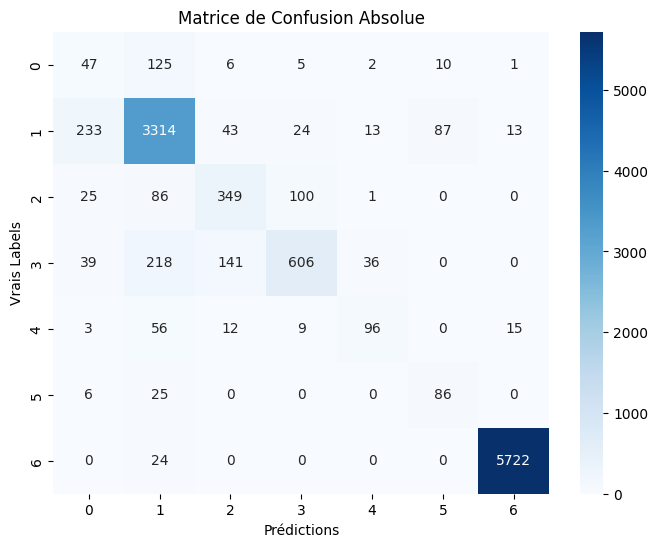

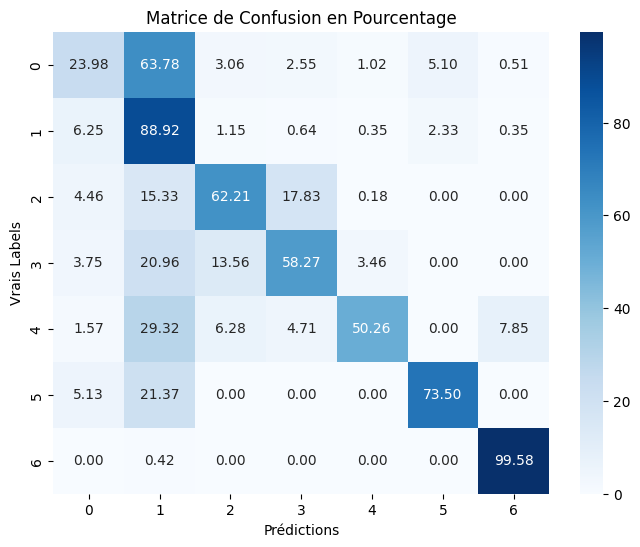

100%|██████████| 2285/2285 [03:59<00:00,  9.52it/s]


Features sauvegardées : C:\Users\rouat\Desktop\final\features\train_features.csv, shape=(36552, 2048)


100%|██████████| 336/336 [00:16<00:00, 20.53it/s]


Features sauvegardées : C:\Users\rouat\Desktop\final\features\val_features.csv, shape=(5376, 2048)


100%|██████████| 724/724 [00:34<00:00, 21.14it/s]


Features sauvegardées : C:\Users\rouat\Desktop\final\features\test_features.csv, shape=(11578, 2048)
Modèle sauvegardé et features extraites.


In [ ]:
# Entraînement de ResNet50 et extraction des deep features pour classification d’images.


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pandas as pd


# Paramètres

train_dir = r"C:\Users\rouat\Desktop\final\train\by_behavior"
val_dir   = r"C:\Users\rouat\Desktop\final\val\by_behavior"
test_dir  = r"C:\Users\rouat\Desktop\final\test\by_behavior"
output_dir = r"C:\Users\rouat\Desktop\final\features"
os.makedirs(output_dir, exist_ok=True)

batch_size = 16
num_epochs = 100
learning_rate = 1e-4
patience = 15


# Transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# Chargement datasets

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset   = ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# Modèle ResNet50 pré-entraîné

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
num_classes = len(train_dataset.classes)
#le Fully Connected Layer

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)
# Freezer les couches de bas niveau pour fine-tuning
for name, param in model.named_parameters():
    if "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

# Fonction d'évaluation
def evaluate(model, dataloader):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(dataloader), correct / total

# Entraînement avec EarlyStopping
best_val_loss = float("inf")
best_model_wts = None
epochs_no_improve = 0

train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict().copy()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping déclenché.")
            break

# Courbes
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.png")
plt.close()

plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve.png")
plt.close()

#  Matrice de confusion
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm_abs = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm_abs, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vrais Labels")
plt.title("Matrice de Confusion Absolue")
plt.show()

# Extraction et sauvegarde des features
feature_extractor = nn.Sequential(*list(model.children())[:-1])

def extract_features(loader, output_csv):
    model.eval()
    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            feats = feature_extractor(images).squeeze(-1).squeeze(-1)
            features_list.append(feats.cpu())
            labels_list.append(labels)
    features = torch.cat(features_list).numpy()
    labels = torch.cat(labels_list).numpy()
    filenames = [os.path.basename(f[0]) for f in loader.dataset.imgs]
    timestamps = [name.split("_")[0] for name in filenames]
    object_ids = [name.split("_")[1] for name in filenames]
    df = pd.DataFrame(features, columns=[f"feat_{i}" for i in range(features.shape[1])])
    df["timestamp"] = timestamps
    df["object_id"] = object_ids
    df["label"] = labels
    df.to_csv(output_csv, index=False)
    print(f"Features sauvegardées : {output_csv}, shape={features.shape}")

extract_features(train_loader, os.path.join(output_dir, "train_features.csv"))
extract_features(val_loader, os.path.join(output_dir, "val_features.csv"))
extract_features(test_loader, os.path.join(output_dir, "test_features.csv"))


torch.save(model.state_dict(), os.path.join(output_dir, "resnet50_cow_behavior_finetune.pth"))
print("Modèle sauvegardé et features extraites.")



In [ ]:
from sklearn.metrics import classification_report

# Rapport de classification
class_names = test_dataset.classes  

report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
print("Rapport de Classification :\n")
print(report)

# Sauvegarde dans un fichier texte
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write(report)
print(f"Rapport de classification sauvegardé dans {output_dir}/classification_report.txt")


Rapport de Classification :

              precision    recall  f1-score   support

           1       0.13      0.24      0.17       196
           2       0.86      0.89      0.87      3727
           3       0.63      0.62      0.63       561
           4       0.81      0.58      0.68      1040
           5       0.65      0.50      0.57       191
           6       0.47      0.74      0.57       117
           7       0.99      1.00      1.00      5746

    accuracy                           0.88     11578
   macro avg       0.65      0.65      0.64     11578
weighted avg       0.89      0.88      0.89     11578

Rapport de classification sauvegardé dans C:\Users\rouat\Desktop\final\features/classification_report.txt


Standardisation des features extraites et réduction de dimension par PCA 

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Dossiers

input_dir = r"C:\Users\rouat\Desktop\final\features"         
output_dir_pca = r"C:\Users\rouat\Desktop\final\features_pca" 
os.makedirs(output_dir_pca, exist_ok=True)


# Charger les features générés par ResNet50

train_df = pd.read_csv(os.path.join(input_dir, "train_features.csv"))
val_df   = pd.read_csv(os.path.join(input_dir, "val_features.csv"))
test_df  = pd.read_csv(os.path.join(input_dir, "test_features.csv"))

feature_cols = [col for col in train_df.columns if col.startswith("feat_")]

X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values
X_test  = test_df[feature_cols].values

# Standardisation
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

# PCA 
pca = PCA(n_components=0.9, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca   = pca.transform(X_val_std)
X_test_pca  = pca.transform(X_test_std)

print(f"Dimension originale : {X_train.shape[1]}, après PCA : {X_train_pca.shape[1]}")

def create_df_pca(X_pca, df_orig):
    df_new = pd.DataFrame(X_pca, columns=[f"feat_{i}" for i in range(X_pca.shape[1])])
    df_new["timestamp"] = df_orig["timestamp"]
    df_new["object_id"] = df_orig["object_id"]
    df_new["label"]     = df_orig["label"]
    return df_new

train_pca_df = create_df_pca(X_train_pca, train_df)
val_pca_df   = create_df_pca(X_val_pca, val_df)
test_pca_df  = create_df_pca(X_test_pca, test_df)

# Sauvegarde
train_pca_df.to_csv(os.path.join(output_dir_pca, "train_features_pca.csv"), index=False)
val_pca_df.to_csv(os.path.join(output_dir_pca, "val_features_pca.csv"), index=False)
test_pca_df.to_csv(os.path.join(output_dir_pca, "test_features_pca.csv"), index=False)

print(" Features standardisées + PCA sauvegardées dans :", output_dir_pca)


Dimension originale : 2048, après PCA : 852
 Features standardisées + PCA sauvegardées dans : C:\Users\rouat\Desktop\final\features_pca


Fusion des deep features  avec les features handcrafted

In [ ]:
import pandas as pd
import os


pca_dir = r"C:\Users\rouat\Desktop\final\features_pca"         
handcrafted_dir = r"C:\Users\rouat\Desktop\final"              
output_dir = r"C:\Users\rouat\Desktop\final\features_fusion"  
os.makedirs(output_dir, exist_ok=True)

# Charger les deep_features
train_pca = pd.read_csv(os.path.join(pca_dir, "train_features_pca.csv"))
val_pca   = pd.read_csv(os.path.join(pca_dir, "val_features_pca.csv"))
test_pca  = pd.read_csv(os.path.join(pca_dir, "test_features_pca.csv"))

# Charger handcrafted features
hand_train = pd.read_csv(r"C:\Users\rouat\Desktop\final\train\annotations_train_scaled.txt", sep=" ")
hand_val   = pd.read_csv(r"C:\Users\rouat\Desktop\final\val\annotations_val_scaled.txt", sep=" ")
hand_test  = pd.read_csv(r"C:\Users\rouat\Desktop\final\test\annotations_test_scaled.txt", sep=" ")

# Fonction de fusion (inner join sur timestamp + object_id)
def fusionner(pca_df, hand_df, name):
    merged = pd.merge(
        pca_df, hand_df,
        on=["timestamp", "object_id"],
        how="inner"  
    )
    out_path = os.path.join(output_dir, f"{name}_fusion.csv")
    merged.to_csv(out_path, index=False)
    print(f"{name} fusion : {merged.shape}, sauvegardé dans {out_path}")
    return merged

# Fusionner datasets
train_fusion = fusionner(train_pca, hand_train, "train")
val_fusion   = fusionner(val_pca, hand_val, "val")
test_fusion  = fusionner(test_pca, hand_test, "test")


train fusion : (36552, 886), sauvegardé dans C:\Users\rouat\Desktop\final\features_fusion\train_fusion.csv
val fusion : (5376, 886), sauvegardé dans C:\Users\rouat\Desktop\final\features_fusion\val_fusion.csv
test fusion : (11578, 886), sauvegardé dans C:\Users\rouat\Desktop\final\features_fusion\test_fusion.csv


In [ ]:

fusion_dir = r"C:\Users\rouat\Desktop\final\features_fusion"

files = ["train_fusion.csv", "val_fusion.csv", "test_fusion.csv"]

for f in files:
    path = os.path.join(fusion_dir, f)
    df = pd.read_csv(path)
    
    if 'label' in df.columns:
        df = df.drop(columns=['label'])
        df.to_csv(path, index=False)
        print(f"'label' supprimé dans {f}")
    else:
        print(f"Aucune colonne 'label' trouvée dans {f}")


'label' supprimé dans train_fusion.csv
'label' supprimé dans val_fusion.csv
'label' supprimé dans test_fusion.csv
